# Wilson and Cowan network simulation

The Wilson and Cowan equations describe the dynamics of interacting excitatory and inhibitory neuronal populations:

\begin{aligned}
    \tau_E \frac{dE}{dt} &= -E + f_E(W_{EE}E - W_{EI}I + I_{ext} + η_E) \\
    \tau_I \frac{dI}{dt} &= -I + f_I(W_{IE}E - W_{II}I + η_I)
\end{aligned}

where

\begin{aligned}
f_Y(x) =
\begin{cases}
    0, & \text{if } x < \theta_Y \\
    g_Y(x - \theta_Y), & \text{if } x \geq \theta_Y
\end{cases}, \quad Y = \{E, I\}.
\end{aligned}

<br>

Using these equations, we can approximate the firing rate of and E-I network over time:

![E-Inetwork](https://github.com/saraysoldado/E-I_network_DEMO/blob/main/E-Inetwork.png?raw=true)

Lets simulate it!

We will try to make both neural populatios fire at a constant rate, as its shown in the picture, and as we observe in experimental data.

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

#%% FUNCTIONS

np.random.seed(42)

def ReLU(x, gain, threshold):
    """Rectified Linear Unit function."""
    return gain * np.maximum(0, x - threshold)

def initialize_plot(tmax):
    """Initialize the plot for excitatory (E) and inhibitory (I) neurons."""
    plt.ion()
    fig, ax = plt.subplots(figsize=(6, 4))
    x_vals = np.arange(tmax) / 10
    line_exc, = ax.plot(x_vals, np.zeros(tmax), label='E', color='r', linewidth=1.5)
    line_inh, = ax.plot(x_vals, np.zeros(tmax), label='I', color='b', linewidth=1.5)

    ax.set_ylim(-0.02, 16)
    ax.set_xlabel('Time (ms)', fontsize=16)
    ax.set_ylabel('E/I (Hz)', fontsize=16)
    ax.legend(fontsize=16)
    ax.grid()
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    return fig, ax, line_exc, line_inh, x_vals

def update_plot(line_exc, line_inh, hR):
    """Update the plot with new simulation data."""
    line_exc.set_ydata(hR[:, 1])
    line_inh.set_ydata(hR[:, 0])
    plt.draw()
    plt.pause(0.01)

def run_simulation(WEE, WEI, WIE, WII, EvokedAmp, EvokedDur_ms,thetaE, thetaI,
                   gainE, gainI, Etau, Itau, dt, time, GRAPHICS=True):

    """Run the E/I neural population model simulation."""

    tmax = int(time / dt)

    E_MAX, I_MAX = 100, 250
    OUtau, OUmu, OUsigma = 0.1, 0, 0.1

    # Evoked Current
    EvokedOn, EvokedDur = int(250 / dt), int(EvokedDur_ms / dt)
    evoked = np.zeros(tmax)
    evoked[EvokedOn:EvokedOn + EvokedDur] = EvokedAmp

    # Initialize Variables
    E, I, OUE, OUI = 0, 0, 0, 0
    hR = np.zeros((tmax, 2))

    # Initialize Plot if needed
    if GRAPHICS:
        fig, ax, line_exc, line_inh, x_vals = initialize_plot(tmax)

    # Simulation Loop
    for t in range(tmax):
        OUE += OUtau * (OUmu - OUE) + OUsigma * np.random.randn()
        OUI += OUtau * (OUmu - OUI) + OUsigma * np.random.randn()

        E += (-E + ReLU(WEE * E - WEI * I + evoked[t] + OUE, gainE, thetaE)) / Etau
        I += (-I + ReLU(WIE * E - WII * I + OUI, gainI, thetaI)) / Itau

        E, I = min(E, E_MAX), min(I, I_MAX)
        hR[t, :] = [I, E]

    # Update Plot if needed
    if GRAPHICS:
        update_plot(line_exc, line_inh, hR)
        plt.ioff()
        plt.show()

    return hR



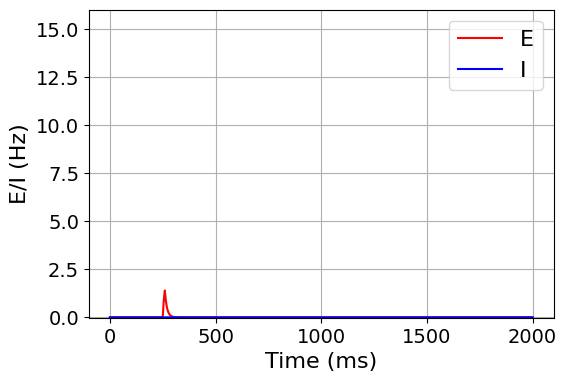

In [71]:
#%% RUN THE SIMULATION

dt = 0.1  #in ms
time = 2000

# Neuron Parameters
thetaE, thetaI = 4.8, 25
gainE, gainI = 1, 4
Etau, Itau = 10 / dt, 2 / dt

WEE = 0
WEI = 0
WIE = 0
WII = 0

EvokedAmp = 7
EvokedDur_ms = 10  # Duration in milliseconds #10

hR = run_simulation(WEE, WEI, WIE, WII, EvokedAmp, EvokedDur_ms,thetaE, thetaI,
                   gainE, gainI, Etau, Itau, dt, time, GRAPHICS=True)


Is there any "magic" combination of weights that would make this work?

Yes there is!

Lets asume that the E and I population are firing at a relatively constant rate, as we see in the experiments. Instead of naming a rate, we will just asign the variables the generic values $E=Eset$ and $I=Iset$.

Now, because the firing rate is somehow constant, the system does not change over time, so we set:

$dE/dt = 0$

$dI/dt = 0$

This is called the "steady state solution" for the differential equations. In this scenario, it becomes straightforward to solve this equation and obtain a solution for the weight parameters, for example WEI and WIE:

\begin{aligned}
W_{EI} =
\frac{W_{EE} E_{\text{Set}}}{I_{\text{Set}}}
- \frac{\theta_E g_E + E_{\text{Set}}}{I_{\text{Set}} g_E}    
\end{aligned}

\begin{aligned}
W_{II} =
\frac{W_{IE} E_{\text{Set}}}{I_{\text{Set}}}
- \frac{\theta_I g_I + I_{\text{Set}}}{I_{\text{Set}} g_I}  
\end{aligned}

The excitatory and inhibitory weights obey a liner relationship, in other words, to be on a steady state of firing, they must be "balanced"!

Lets check this relationship out and later simulate it to see if its true :)

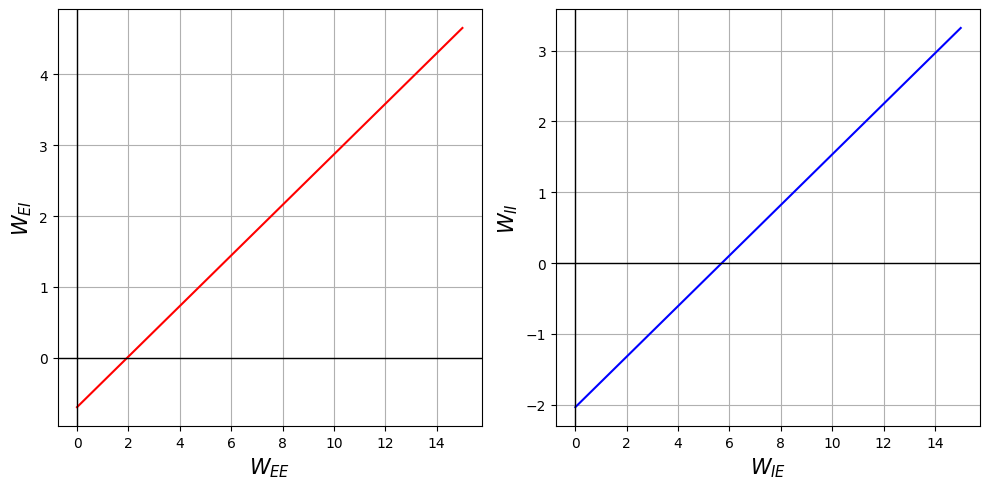

In [72]:
# Plot weight relationship

# Updated E_set and I_set values
Eset, Iset = 5, 14

# Define range for W_EE and W_IE
WEEvalues = np.linspace(0, 15, 15)
WIEvalues = np.linspace(0, 15, 15)

# Compute W_EI and W_II
WEIvalues = (WEEvalues * Eset / Iset) - ((thetaE * gainE + Eset) / (Iset * gainE))
WIIvalues = (WIEvalues * Eset / Iset) - ((thetaI * gainI + Iset) / (Iset * gainI))

# Plot the equations
plt.figure(figsize=(10, 5))

# Plot W_EI
plt.subplot(1, 2, 1)
plt.plot(WEEvalues, WEIvalues, label=r'$W_{EI}$', linewidth=1.5, color='red')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.xlabel(r'$W_{EE}$',fontsize=15)
plt.ylabel(r'$W_{EI}$',fontsize=15)
plt.grid()

# Plot W_II
plt.subplot(1, 2, 2)
plt.plot(WIEvalues, WIIvalues, label=r'$W_{II}$', linewidth=1.5, color='blue')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.xlabel(r'$W_{IE}$',fontsize=15)
plt.ylabel(r'$W_{II}$',fontsize=15)
plt.grid()

plt.tight_layout()
plt.show()

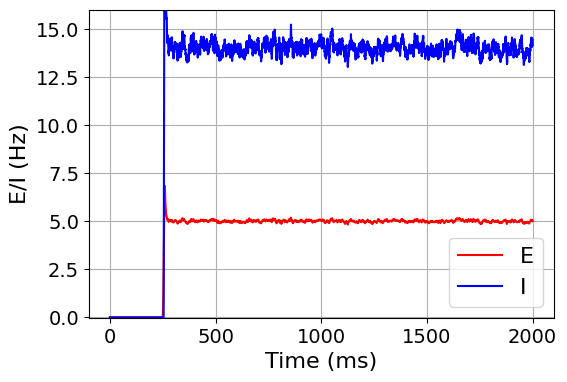

In [73]:
#%% RUN THE SIMULATION

dt = 0.1  #in ms
time = 2000

Eset, Iset = 5, 14

# Neuron Parameters
thetaE, thetaI = 4.8, 25
gainE, gainI = 1, 4
Etau, Itau = 10 / dt, 2 / dt

WEE = 5
WEI = (WEE * Eset / Iset) - ((thetaE * gainE + Eset) / (Iset * gainE))
WIE = 10
WII = (WIE * Eset / Iset) - ((thetaI * gainI + Iset) / (Iset * gainI))


EvokedAmp = 7
EvokedDur_ms = 10  # Duration in milliseconds #10

hR = run_simulation(WEE, WEI, WIE, WII, EvokedAmp, EvokedDur_ms,thetaE, thetaI,
                   gainE, gainI, Etau, Itau, dt, time, GRAPHICS=True)